In [44]:
# Standard library imports
import sys
import warnings
import joblib
import os


# Third-party library imports
import pandas as pd
import scipy.stats as stats
import xgboost as xg
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Adding 'src' folder path to import path
sys.path.append('../src')

# Local application imports (custom modules)
from classes import Auxiliaries, Modelling, Plot

In [45]:
# Create objects for data visualization and modeling
plotter = Plot(figsize=(10, 6), palette='viridis')
modelling = Modelling()
aux = Auxiliaries(plotter)

# Ignore warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# read the csv file
data = pd.read_csv("../data/teste_indicium_precificacao.csv")

In [47]:
# convert 'ultima_review' in data format
data['ultima_review'] = pd.to_datetime(data['ultima_review'])

# An√°lise Explor√°toria dos Dados

##  An√°lise por Bairro - ```bairro_group```

A seguir, analisamos a vari√°vel `bairro_group`, que indica o bairro onde cada an√∫ncio est√° localizado.       

Observamos que a maioria dos an√∫ncios est√£o concentrados em **Manhattan** e no **Brooklyn**, que juntos representam mais de 80% do total. **Manhattan** se destaca como o bairro com a maior quantidade de an√∫ncios, correspondendo a 44,3% do total, seguido pelo Brooklyn, que representa pouco mais de 40%.    

Os demais bairros ‚Äî **Queens**, **Bronx** e **Staten Island** ‚Äî possuem uma participa√ß√£o menor no n√∫mero de an√∫ncios. Queens e Bronx representam cada um menos de 12%, enquanto **Staten Island** apresenta a menor propor√ß√£o, com apenas 0,8% dos an√∫ncios.

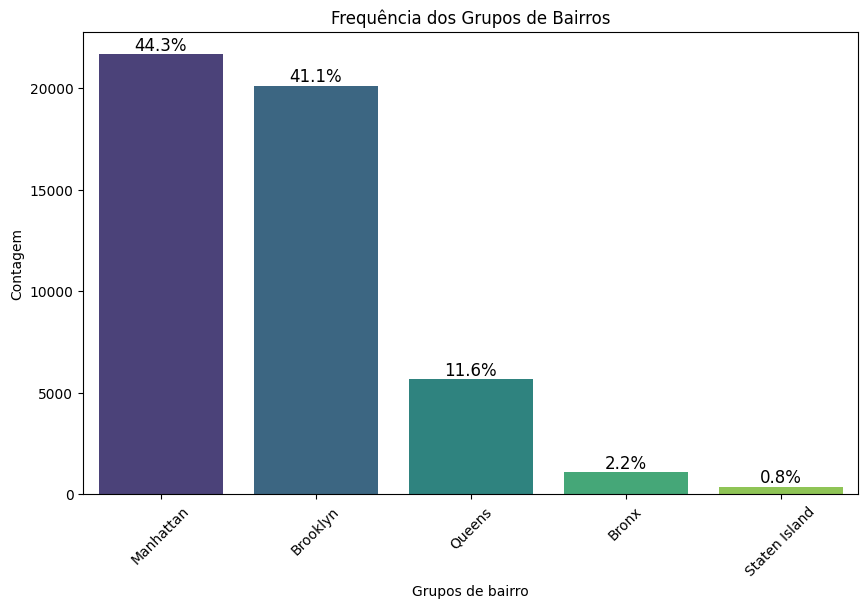

In [48]:
# Bairro group count
bairro_group_count = data["bairro_group"].value_counts().reset_index()
bairro_group_count.columns = ["bairro_group", "count"]

# Using Plot class to plot bar graph
plotter.barplot(
    data=bairro_group_count,
    x_col="bairro_group",
    y_col="count",
    title="Frequ√™ncia dos Grupos de Bairros",
    xlabel="Grupos de bairro",
    ylabel="Contagem",
    rotation=45,
    show_percentage=True,
)
 


A seguir, analisamos tamb√©m o pre√ßo m√©dio dos grupos de bairros. Observamos que os dois bairros com maior n√∫mero de an√∫ncios, **Manhattan** e **Brooklyn**, tamb√©m apresentam os pre√ßos m√©dios mais elevados. Manhattan possui o maior valor, com uma m√©dia de 197 d√≥lares por noite, enquanto o **Brooklyn** apresenta um pre√ßo m√©dio de 124 d√≥lares.    

Nos bairros com menor quantidade de an√∫ncios, a rela√ß√£o entre participa√ß√£o e pre√ßo m√©dio se altera. Apesar de **Staten Island**representar apenas 0,8% dos an√∫ncios, seu pre√ßo m√©dio √© de 115 d√≥lares, superior ao de Queens e Bronx. Al√©m disso, o valor m√©dio de **Staten Island** se aproxima do pre√ßo m√©dio do **Brooklyn**, destacando-se entre os bairros com menor n√∫mero de an√∫ncios.

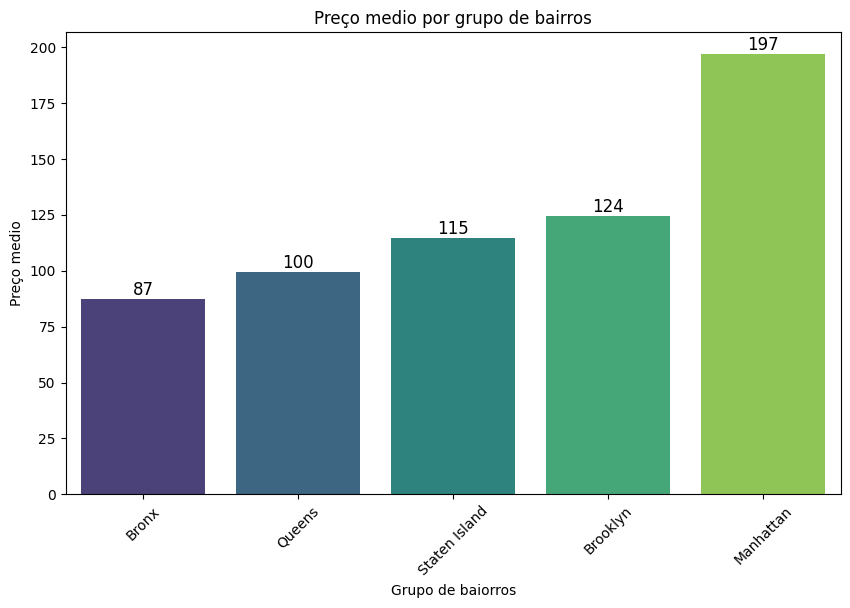

In [49]:
# Calculate the mean price by room type
mean_price_by_room_type = (
    data.groupby("bairro_group")["price"].mean().sort_values()
)

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(
    data=mean_price_by_room_type_df,
    x_col="bairro_group",
    y_col="price",
    title="Pre√ßo medio por grupo de bairros",
    xlabel="Grupo de baiorros",
    ylabel="Pre√ßo medio",
    rotation=45,
    show_percentage=False,
)


Na an√°lise a seguir, observamos um comportamento interessante: os dois bairros com maior n√∫mero de an√∫ncios apresentam os menores n√∫meros m√©dios de avalia√ß√µes. **Manhattan** possui, em m√©dia, 21 avalia√ß√µes por an√∫ncio, enquanto **Brooklyn** tem 24.    

Por outro lado, os bairros com menor quantidade de an√∫ncios se destacam por terem um maior n√∫mero m√©dio de avalia√ß√µes. **Staten Island** apresenta a maior m√©dia, com 31 avalia√ß√µes por an√∫ncio, seguido por **Queens**, com 28, e **Bronx**, com 26. Esse resultado contrasta com as an√°lises anteriores, indicando que, embora **Manhattan** e **Brooklyn** concentrem a maior parte dos an√∫ncios e tenham os pre√ßos mais elevados, os bairros com menos an√∫ncios parecem ter uma maior intera√ß√£o dos h√≥spedes, refletida no maior n√∫mero de avalia√ß√µes.

In [50]:
# Calculate the mean price by bairro_group
mean_price_by_bairro_group = (
    data.groupby("bairro_group")["numero_de_reviews"].mean().sort_values()
)

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_bairro_group_df = mean_price_by_bairro_group.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(
    data=mean_price_by_bairro_group_df,
    x_col="bairro_group",
    y_col="numero_de_reviews",
    title="N√∫mero medio de review por grupos de bairro",
    xlabel="Grupos de bairro",
    ylabel="numero e reviews",
    rotation=45,
    show_percentage=False,
)


# An√°lise por tipos de quarto - `room_type`

A an√°lise da vari√°vel **tipo de quarto** (`room_type`), que indica o tipo de espa√ßo de cada an√∫ncio, revela que os tipos de espa√ßo mais comuns s√£o **casa inteira** e **quartos privados**. Esses dois tipos de espa√ßo representam a maior parte dos an√∫ncios, sugerindo que os clientes preferem op√ß√µes que ofere√ßam maior **privacidade e conforto**. Isso reflete a tend√™ncia de que os h√≥spedes buscam locais mais exclusivos, como casas inteiras e quartos privados, para garantir uma experi√™ncia mais intimista durante a estadia.

Em contrapartida, o n√∫mero de an√∫ncios de **quartos compartilhados** √© significativamente menor, indicando que esse tipo de espa√ßo tem uma procura bem mais baixa. Isso sugere que as pessoas, em sua maioria, preferem pagar um pouco mais por maior privacidade, ao inv√©s de optar por um ambiente compartilhado, que pode oferecer uma experi√™ncia menos confort√°vel. 

Portanto, a an√°lise sugere que a busca por privacidade √© um fator importante para os clientes, com **casas inteiras** e **quartos privados** sendo as op√ß√µes mais procuradas.

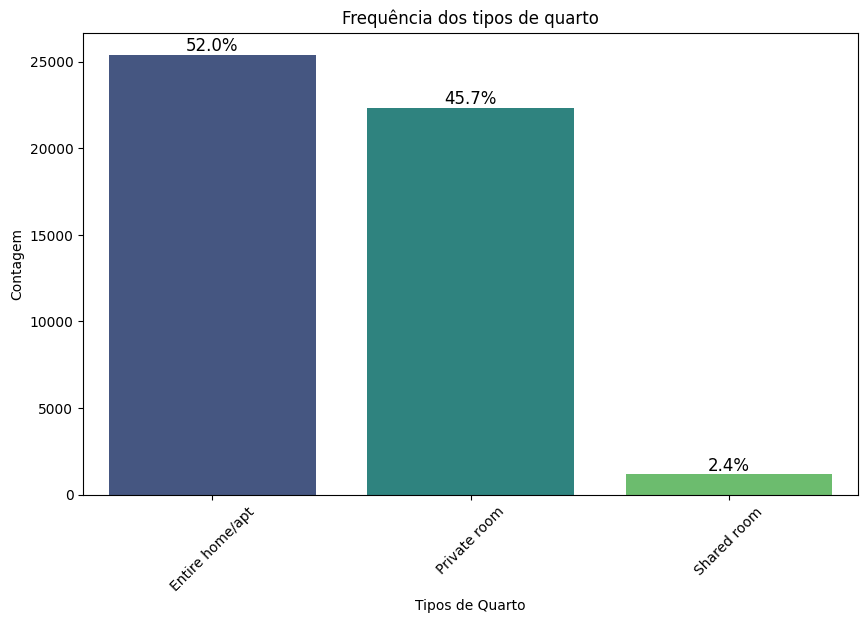

In [51]:
# Room type count
room_type_count = data["room_type"].value_counts().reset_index()
room_type_count.columns = ["room_type", "count"]

# Using Plot class to plot bar graph
plotter.barplot(
    data=room_type_count,
    x_col="room_type",
    y_col="count",
    title="Frequ√™ncia dos tipos de quarto",
    xlabel="Tipos de Quarto",
    ylabel="Contagem",
    rotation=45,
    show_percentage=True,
)


A an√°lise do tipo de espa√ßo revelou que h√° uma varia√ß√£o significativa nos pre√ßos m√©dios. O tipo de espa√ßo com a m√©dia de pre√ßo mais alta √© a **casa inteira**, que tem um valor superior a 200 d√≥lares. Esse pre√ßo mais elevado pode ser justificado pela maior privacidade, conforto e capacidade de acomodar mais pessoas, caracter√≠sticas que tornam as casas inteiras uma op√ß√£o mais cara em compara√ß√£o com os outros tipos de espa√ßo.

Por outro lado, os outros tipos de espa√ßo, como **quartos privados** e **quartos compartilhados**, apresentam uma m√©dia de pre√ßo bem mais baixa, com valores abaixo de 100 d√≥lares. Isso se deve ao fato de que esses espa√ßos oferecem menos privacidade e t√™m uma capacidade de acomoda√ß√£o reduzida, o que geralmente resulta em pre√ßos mais acess√≠veis.

In [52]:
# Calculate the mean price by room_type
mean_price_by_room_type = data.groupby("room_type")["price"].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(
    data=mean_price_by_room_type_df,
    x_col="room_type",
    y_col="price",
    title="Pre√ßo medio por grupo de bairros",
    xlabel="Grupo de Bairros",
    ylabel="Pre√ßo M√©dio",
    rotation=45,
    show_percentage=False,
)


## An√°lise por nome e textos - ```nome```

Abaixo, apresentamos a an√°lise dos nomes mais comuns na vari√°vel `nome`, que representa o t√≠tulo do an√∫ncio.  

Essas palavras s√£o utilizadas para atrair clientes e fornecer uma breve descri√ß√£o do espa√ßo. Entre as mais frequentes, destacam-se:  

- **heart** ‚Äì cora√ß√£o  
- **private** ‚Äì privado  
- **room** ‚Äì quarto  
- **apartment** ‚Äì apartamento  
- **cozy** ‚Äì aconchegante  
- **home** ‚Äì lar/casa  
- **spacious** ‚Äì espa√ßoso  

Essas palavras enfatizam o conforto e as caracter√≠sticas do local, ajudando a tornar os an√∫ncios mais atrativos para os poss√≠veis h√≥spedes.

In [ ]:
# Generate a word cloud for the 'nome' column in the 'data' DataFrame
df_commom_words = plotter.plot_wordcloud(
    data, text_column="nome", title="Palavras mais comuns nos nomes do anuncio"
)


## An√°lise por g√™nero - ```host_name```

Para a an√°lise a seguir, realizamos um pr√©-processamento nos dados e criamos uma nova coluna a partir da vari√°vel `host_name`, que cont√©m o nome do anfitri√£o do an√∫ncio. O objetivo foi identificar o g√™nero do anunciante, permitindo avaliar poss√≠veis diferen√ßas nos pre√ßos ou no n√∫mero de an√∫ncios com base nesse crit√©rio.  

Os resultados mostram que a categoria mais comum √© "Andy" ou andr√≥ginos ‚Äì nomes que n√£o conseguimos classificar com precis√£o ‚Äì, representando 26% do total. Al√©m disso, alguns nomes n√£o puderam ser rotulados como masculinos ou femininos, sendo categorizados como "Desconhecido".  

No geral, observamos que h√° mais anfitri√µes do g√™nero masculino do que feminino, com os homens representando 24,8% dos an√∫ncios, enquanto as mulheres correspondem a 21,2%.

In [ ]:
# Apply predict_gender in 'host_name' column
data["gender"] = data["host_name"].apply(lambda name: aux.predict_gender(name))

# Replace specific gender values for consistency
data["gender"] = data["gender"].replace({"mostly_female": "female", "mostly_male": "male"})

# Check the unique values in the 'gender' column
print(data["gender"].unique())

# Group by 'gender' and calculate the mean price
gender_price_mean = data.groupby("gender")["price"].mean().reset_index()

# Use the Plot class to generate a bar chart
plotter.barplot(
    data=gender_price_mean,
    x_col="gender",
    y_col="price",
    title="Pre√ßo m√©dio por g√™nero",
    xlabel="G√™nero",
    ylabel="Pre√ßo M√©dio",
    rotation=45,
)



['female' 'unknown' 'male' 'andy']


## An√°lise de Pre√ßos - ```price```

Continuaremos nossas an√°lises com a coluna `price`, que cont√©m o pre√ßo por noite em d√≥lares listado pelo anfitri√£o.  

Podemos ver pelo gr√°fico boxplot que os pre√ßos apresentam alta variabilidade, o que pode gerar dificuldades nas previs√µes no futuro. O boxplot revela que a maioria dos valores est√£o concentrados em pontos discrepantes, com valores acima de 1.000 d√≥lares situados fora da faixa do boxplot.  

Analisando os principais percentis dos pre√ßos, temos os seguintes valores:


- **M√≠nimo (0%)**: 0,00 ‚Äì Este valor representa o menor pre√ßo registrado na base de dados, sem considerar os outliers. Um valor de 0,00 pode indicar casos at√≠picos ou erros de inser√ß√£o de dados, ou at√© mesmo an√∫ncios gratuitos.  

- **Primeiro quartil (25%)**: 69,00 ‚Äì 25% dos pre√ßos dos an√∫ncios est√£o abaixo de 69,00 d√≥lares.A maioria dos pre√ßos est√° concentrada abaixo desse valor, sugerindo que uma boa parte dos an√∫ncios possui pre√ßos mais baixos. 

- **Mediana (50%)**: 106,00 ‚Äì A mediana representa o valor central da distribui√ß√£o de pre√ßos. 

- **Terceiro quartil (75%)**: 175,00 ‚Äì 75% dos pre√ßos dos an√∫ncios est√£o abaixo de 175,00 d√≥lares.

- **M√°ximo (100%)**: 10.000,00 ‚Äì Este √© o maior pre√ßo registrado, sem considerar outliers. O valor de 10.000 d√≥lares √© um exemplo de um pre√ßo extremo, possivelmente relacionado a an√∫ncios de luxo ou propriedades excepcionais. Esses valores muito altos podem ser considerados outliers, j√° que est√£o bem distantes da maioria dos pre√ßos.

Esses valores revelam uma distribui√ß√£o de pre√ßos com uma grande variabilidade, com uma concentra√ß√£o de valores mais baixos, mas com a presen√ßa de alguns valores extremamente altos que podem distorcer a an√°lise geral dos pre√ßos. 

Esses valores indicam que a distribui√ß√£o de pre√ßos tem uma grande dispers√£o, com um n√∫mero significativo de pre√ßos muito altos, o que pode indicar a presen√ßa de an√∫ncios de luxo ou com caracter√≠sticas especiais. Al√©m disso, a grande diferen√ßa entre o m√≠nimo e o m√°ximo, com outliers extremos, destaca a necessidade de tratativas adicionais para esses dados nas an√°lises e previs√µes futuras.

In [ ]:
# Plot the boxplot for 'price' (without x_col)
plotter.boxplot(
    data=data,
    x_col=None,
    y_col="price",
    title="Boxplot dos pre√ßos dos anuncios",
    ylabel="Pre√ßo",
)


Analisando a coluna `minimo_noites`, que cont√©m o n√∫mero m√≠nimo de noites que o usu√°rio deve reservar, podemos observar alguns padr√µes interessantes ao segmentar os pre√ßos com base nos valores dessa coluna.  

Primeiramente, ao separar os pre√ßos pelos diferentes n√∫meros de noites m√≠nimas exigidas pelos anfitri√µes e observar o boxplot, percebemos que a concentra√ß√£o m√©dia dos pre√ßos n√£o apresenta grandes diferen√ßas entre os valores de `minimo_noites`. Em todas as categorias, o pre√ßo m√©dio est√° em torno de 155 d√≥lares por noite, conforme ilustrado tanto pelo boxplot quanto pela tabela da vari√°vel `minimo_noites`.  

No entanto, ao examinar os valores mais elevados, podemos observar que os pre√ßos tendem a ser mais altos quando o n√∫mero m√≠nimo de noites √© **1** e tamb√©m quando √© **30**. Essa tend√™ncia pode sugerir que os an√∫ncios com essas dura√ß√µes m√≠nimas de estadia t√™m caracter√≠sticas especiais ou s√£o de maior valor. Al√©m disso, existe um outlier para o valor de `minimo_noites` igual a **5**, onde o pre√ßo registrado √© significativamente mais alto que os outros. Esse outlier pode indicar um an√∫ncio com caracter√≠sticas excepcionais ou um erro de dados.  

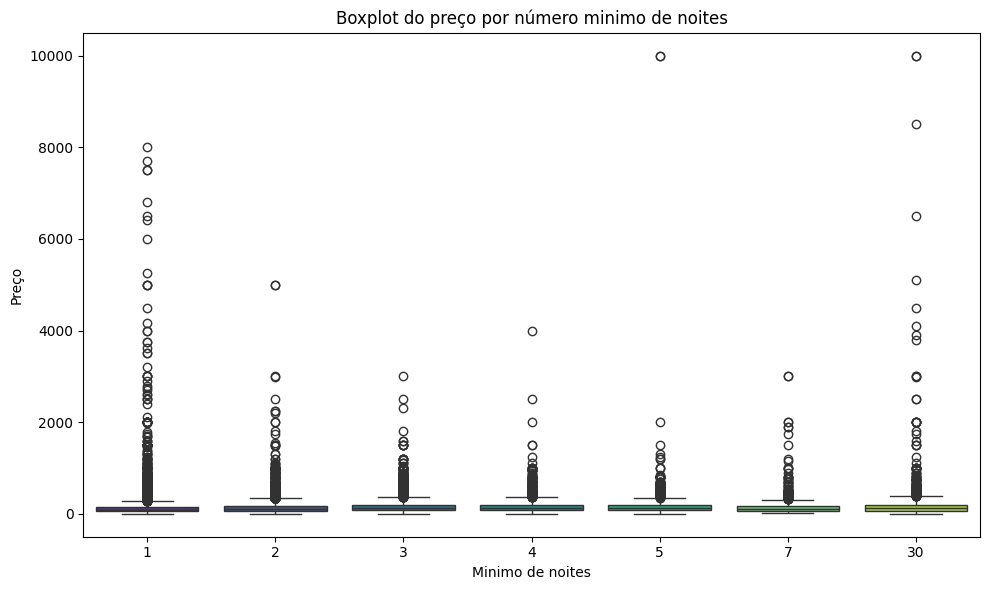

Pre√ßo m√©dio por n√∫mero minimo de noites:
minimo_noites
1     142.02
2     146.27
3     160.25
4     161.19
5     157.31
7     141.19
30    182.56
Name: price, dtype: float64


In [ ]:
# Define the most common values of 'minimo_noites'
common_nights = [1, 2, 3, 30, 4, 5, 7]

# Filter the dataset to include only these values
filtered_data = data[data["minimo_noites"].isin(common_nights)]

# Create the boxplot for 'minimo_noites' using the Plot class
plotter.boxplot(
    data=filtered_data,
    x_col="minimo_noites",
    y_col="price",
    title="Boxplot do pre√ßo por n√∫mero minimo de noites",
    xlabel="Minimo de noites",
    ylabel="Pre√ßo",
)

# Calculate and print the mean prices by 'minimo_noites'
mean_prices = filtered_data.groupby("minimo_noites")["price"].mean()
print("Pre√ßo m√©dio por n√∫mero minimo de noites:")
print(mean_prices.round(2))



## An√°lise de √∫ltima review - `ultima_review`

√â interessante investigar se uma review mais recente impacta no pre√ßo m√©dio de um apartamento, como podemos observar no gr√°fico a seguir, a partir da an√°lise da vari√°vel `ultima_review`, que cont√©m a data da √∫ltima revis√£o dada √† listagem.  

Ao observar o boxplot, podemos perceber que, quanto mais recente a review, maior √© a dispers√£o dos pre√ßos, com um n√∫mero maior de valores mais altos. Isso pode indicar que uma review recente pode estar associada a pre√ßos mais elevados. No entanto, essa observa√ß√£o por si s√≥ n√£o √© suficiente para confirmar uma rela√ß√£o causal entre a rec√™ncia da review e o pre√ßo. 

Para verificar se essa associa√ß√£o √© estatisticamente significativa, realizaremos um teste ANOVA, que ajudar√° a avaliar se h√° uma diferen√ßa significativa nos pre√ßos m√©dios entre diferentes grupos de rec√™ncia das reviews. O p-value obtido a partir do teste ANOVA nos permitir√° determinar se a rec√™ncia das reviews tem um impacto real nos pre√ßos ou se a varia√ß√£o observada pode ser atribu√≠da ao acaso.

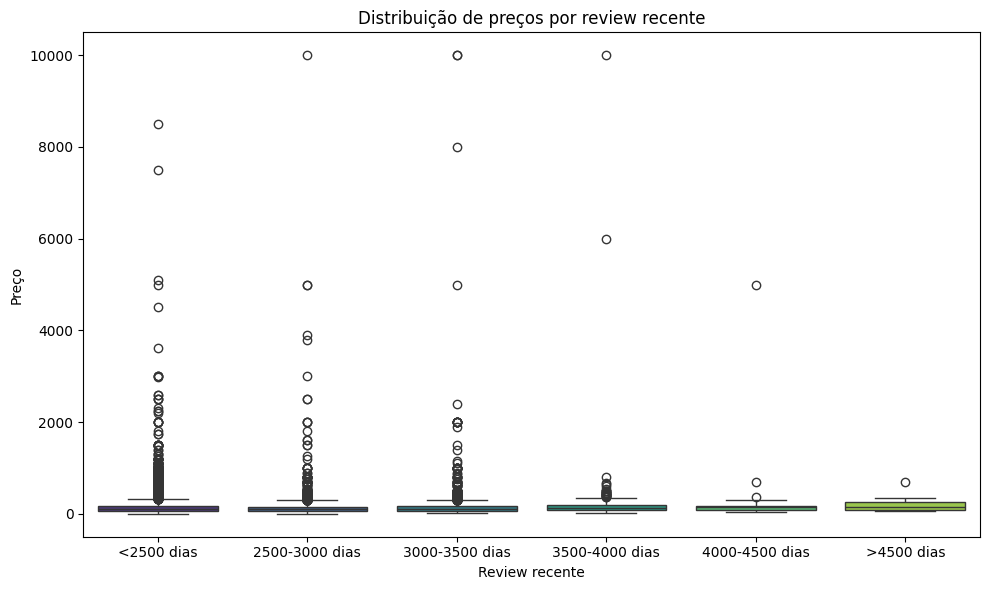

In [ ]:
data["days_since_last_review"] = (pd.Timestamp.today() - data["ultima_review"]).dt.days

# Ensure there are no NaN values in 'days_since_last_review'
data = data.dropna(subset=["days_since_last_review"])

# Define the bins with a lower bound (0)
data["review_recency_category"] = pd.cut(
    data["days_since_last_review"],
    bins=[0, 2500, 3000, 3500, 4000, 4500, data["days_since_last_review"].max()],
    labels=[
        "<2500 dias",
        "2500-3000 dias",
        "3000-3500 dias",
        "3500-4000 dias",
        "4000-4500 dias",
        ">4500 dias",
    ]
)

# Drop NaN values again in case some remain
data = data.dropna(subset=["review_recency_category", "price"])

plotter.boxplot(
    data=data,
    x_col="review_recency_category",
    y_col="price",
    title="Distribui√ß√£o de pre√ßos por review recente",
    xlabel="Review recente",
    ylabel="Pre√ßo",
)
)



O p-value de **5.900678200832663e-07** √© extremamente baixo, muito menor que o limite de 0,05, o que nos permite tirar as seguintes conclus√µes:

- **Rejeitamos a hip√≥tese nula**: A hip√≥tese nula, que pressup√µe que todas as categorias de "review_recency_category" (rec√™ncia das avalia√ß√µes) t√™m m√©dias de pre√ßo iguais, √© rejeitada com um n√≠vel de confian√ßa elevado. Isso significa que n√£o podemos assumir que os pre√ßos s√£o iguais entre os diferentes grupos de rec√™ncia das avalia√ß√µes.
  
- **Diferen√ßas significativas**: O p-value t√£o baixo indica que h√° uma diferen√ßa significativa nas m√©dias de pre√ßo entre as categorias de rec√™ncia das avalia√ß√µes. Em outras palavras, podemos afirmar com confian√ßa que os pre√ßos dos an√∫ncios variam de forma significativa dependendo de qu√£o recente √© a avalia√ß√£o.

- **Influ√™ncia da rec√™ncia**: Com base nesses resultados, podemos concluir que a data da √∫ltima avalia√ß√£o (ou a rec√™ncia dessa avalia√ß√£o) tem um efeito substancial sobre o pre√ßo dos apartamentos. Isso sugere que o tempo desde a √∫ltima revis√£o tem um impacto real e mensur√°vel no valor listado dos apartamentos.

Em resumo, com esse p-value, podemos concluir de forma robusta que a vari√°vel "days_since_last_review", quando transformada em categorias, influencia de maneira significativa o pre√ßo dos apartamentos. A rec√™ncia das avalia√ß√µes parece ser um fator relevante na determina√ß√£o do pre√ßo m√©dio dos an√∫ncios.

In [ ]:
anova_result = stats.f_oneway(
    *[group["price"].dropna() for _, group in data.groupby("review_recency_category")]
)

print("Se o valor p < 0,05, ent√£o a √∫ltima data de revis√£o afeta significativamente o pre√ßo.")
print("Se o valor p > 0,05, n√£o h√° evid√™ncias fortes de que a atualidade da revis√£o impacta o pre√ßo.")
print(f"ANOVA p-value: {anova_result.pvalue}")


Se o valor p < 0,05, ent√£o a √∫ltima data de revis√£o afeta significativamente o pre√ßo.
Se o valor p > 0,05, n√£o h√° evid√™ncias fortes de que a atualidade da revis√£o impacta o pre√ßo.
ANOVA p-value: 4.806640771930744e-07


# Perguntas

## Supondo  que  uma  pessoa  esteja  pensando  em  investir  em  um apartamento para alugar na plataforma, onde seria mais indicada a compra?

A an√°lise sugere que a melhor op√ß√£o de compra seria em **Manhattan** ou **Brooklyn**, considerando os pre√ßos m√©dios de cada bairro. Em Manhattan, o pre√ßo m√©dio √© de **197 d√≥lares**, o que o torna o bairro com o pre√ßo m√©dio mais alto entre os cinco grupos de bairro analisados. Esse valor mais elevado indica que h√° um maior potencial de **faturamento**, o que torna Manhattan uma op√ß√£o atraente para investimentos, pois al√©m de ter o maior pre√ßo m√©dio, tamb√©m representa a maior parte dos an√∫ncios, sugerindo uma demanda significativa.

Em compara√ß√£o, embora o **Brooklyn** tamb√©m seja um bairro popular, com pre√ßos mais acess√≠veis que Manhattan, investir em Manhattan pode ser mais vantajoso devido ao maior retorno financeiro, dado o pre√ßo m√©dio mais elevado e a maior quantidade de an√∫ncios. Portanto, considerando tanto o pre√ßo como a representatividade do bairro no mercado, **Manhattan** se destaca como a melhor op√ß√£o de compra para maximizar o faturamento.

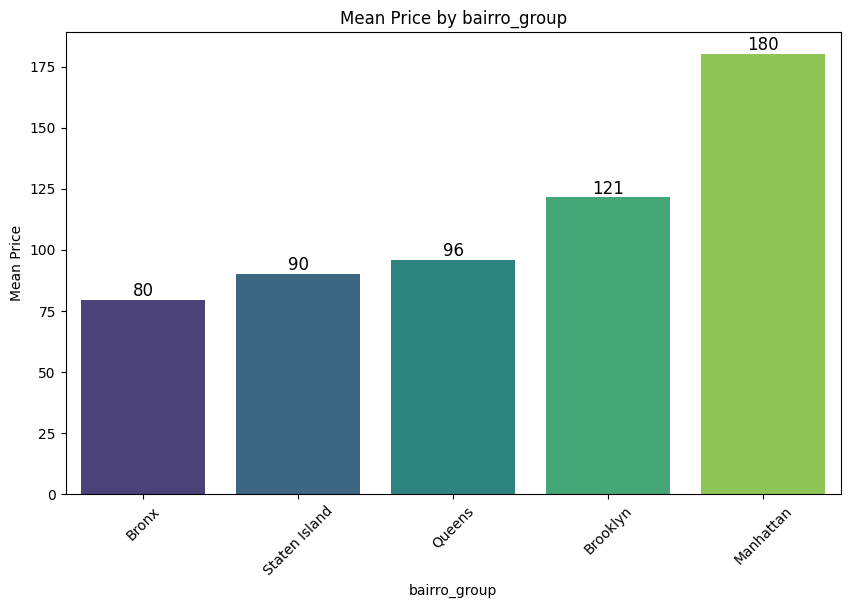

In [ ]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby("bairro_group")["price"].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(
    data=mean_price_by_room_type_df,
    x_col="bairro_group",
    y_col="price",
    title="Mean Price by bairro_group",
    xlabel="bairro_group",
    ylabel="Mean Price",
    rotation=45,
    show_percentage=False,
)


## O n√∫mero m√≠nimo de noites e a disponibilidade ao longo do ano interferem no pre√ßo?

### An√°lise de pre√ßo e N√∫mero M√≠nimo de noites

Para fazer esta an√°lise usamos um teste anova com p-value, com isso obtemos que:
O p-value de **5.900678200832663e-07** √© extremamente baixo, muito menor que o limite de 0,05, o que nos permite tirar as seguintes conclus√µes:

- **Rejeitamos a hip√≥tese nula**: A hip√≥tese nula, que pressup√µe que todas as categorias de "review_recency_category" (rec√™ncia das avalia√ß√µes) t√™m m√©dias de pre√ßo iguais, √© rejeitada com um n√≠vel de confian√ßa elevado. Isso significa que n√£o podemos assumir que os pre√ßos s√£o iguais entre os diferentes grupos de rec√™ncia das avalia√ß√µes.
  
- **Diferen√ßas significativas**: O p-value t√£o baixo indica que h√° uma diferen√ßa significativa nas m√©dias de pre√ßo entre as categorias de rec√™ncia das avalia√ß√µes. Em outras palavras, podemos afirmar com confian√ßa que os pre√ßos dos an√∫ncios variam de forma significativa dependendo de qu√£o recente √© a avalia√ß√£o.

- **Influ√™ncia da rec√™ncia**: Com base nesses resultados, podemos concluir que a data da √∫ltima avalia√ß√£o (ou a rec√™ncia dessa avalia√ß√£o) tem um efeito substancial sobre o pre√ßo dos apartamentos. Isso sugere que o tempo desde a √∫ltima revis√£o tem um impacto real e mensur√°vel no valor listado dos apartamentos.

Em resumo, com esse p-value, podemos concluir de forma robusta que a vari√°vel "days_since_last_review", quando transformada em categorias, influencia de maneira significativa o pre√ßo dos apartamentos. A rec√™ncia das avalia√ß√µes parece ser um fator relevante na determina√ß√£o do pre√ßo m√©dio dos an√∫ncios.


In [ ]:
# Remove any rows with missing values in 'disponibilidade_365' or 'price'
clean_data = data.dropna(subset=["minimo_noites", "price"])

# Perform ANOVA (Analysis of Variance)
anova_result = stats.f_oneway(
    *[group["price"].dropna() for _, group in data.groupby("review_recency_category")]
)

print("Se o valor p < 0,05, ent√£o a √∫ltima data de revis√£o afeta significativamente o pre√ßo.")
print("Se o valor p > 0,05, n√£o h√° evid√™ncias fortes de que a atualidade da revis√£o impacta o pre√ßo.")
print("ANOVA p-value: {}".format(anova_result.pvalue))

# Interpretation of the results
if anova_result.pvalue < 0.05:
    print("Existe uma rela√ß√£o significativa entre 'minimo_noites' e 'price'.")
else:
    print("N√£o h√° rela√ß√£o significativa entre 'minimo_noites' e 'price'.")


Se o valor p < 0,05, ent√£o a √∫ltima data de revis√£o afeta significativamente o pre√ßo.
Se o valor p > 0,05, n√£o h√° evid√™ncias fortes de que a atualidade da revis√£o impacta o pre√ßo.
ANOVA p-value: 4.806640771930744e-07
Existe uma rela√ß√£o significativa entre 'minimo_noites' e 'price'.


### An√°lise de pre√ßo e Disponibilidade ao longo dos Anos

A an√°lise de pre√ßo m√©dio por disponibilidade revela uma rela√ß√£o interessante entre o n√∫mero de dias dispon√≠veis para reserva e o pre√ßo m√©dio do an√∫ncio. Observamos que, para an√∫ncios com baixa disponibilidade, o pre√ßo m√©dio tende a ser mais baixo, variando entre 126 e 136 d√≥lares nos primeiros dias. Conforme a disponibilidade aumenta, os pre√ßos m√©dios tamb√©m sobem gradualmente. Para an√∫ncios com 179 dias dispon√≠veis, o pre√ßo m√©dio j√° atinge 183,57 d√≥lares, e para aqueles com 364 ou 365 dias dispon√≠veis, os pre√ßos m√©dios s√£o os mais altos, chegando a 214,05 d√≥lares.

Essa tend√™ncia sugere que anfitri√µes que deixam seus im√≥veis dispon√≠veis para loca√ß√£o durante todo o ano podem praticar pre√ßos mais elevados, possivelmente devido a maior experi√™ncia na plataforma ou maior demanda por esse tipo de acomoda√ß√£o

In [ ]:
# Define the most common values of 'disponibilidade_365'
common_availability = data["disponibilidade_365"].value_counts().head(10).index

# Filter the dataset to include only these values
filtered_data_availability = data[data["disponibilidade_365"].isin(common_availability)]

# Create the boxplot for 'disponibilidade_365' using the Plot class
plotter.boxplot(
    data=filtered_data_availability,
    x_col="disponibilidade_365",
    y_col="price",
    title="Boxplot Pre√ßos por disponibilidade (365)",
    xlabel="Disponibilidade (365)",
    ylabel="Pre√ßo",
)

# Calculate and print the mean prices by 'disponibilidade_365'
mean_prices_availability = filtered_data_availability.groupby("disponibilidade_365")["price"].mean()
print("Pre√ßos m√©dios por disponibilidade(365):")
print(mean_prices_availability.round(2))


Pre√ßos m√©dios por disponibilidade(365):
disponibilidade_365
0      126.72
1      126.85
2      136.12
3      133.15
5      132.08
89     146.32
90     135.42
179    183.57
364    205.46
365    214.05
Name: price, dtype: float64


Os resultados do teste ANOVA indicam que h√° uma **rela√ß√£o estatisticamente significativa** entre a vari√°vel **"disponibilidade_365"** e o **pre√ßo** dos an√∫ncios. O **F-statistic de 1.75** sugere que h√° uma varia√ß√£o relevante nos pre√ßos m√©dios entre os diferentes grupos de disponibilidade. Al√©m disso, o **p-value extremamente baixo (pr√≥ximo de 0.0000)** permite rejeitar a hip√≥tese nula, que assume que n√£o h√° diferen√ßa significativa nos pre√ßos entre os grupos.

Isso refor√ßa a ideia de que a **quantidade de dias dispon√≠veis** pode ter um impacto direto no pre√ßo praticado pelos anfitri√µes. Como observado na an√°lise anterior, an√∫ncios com maior disponibilidade tendem a ter pre√ßos m√©dios mais elevados, possivelmente devido √† demanda cont√≠nua ou a um perfil de anfitri√µes mais experientes que maximizam os ganhos ao longo do ano.

In [ ]:
# Remove any rows with missing values in 'disponibilidade_365' or 'price'
clean_data = data.dropna(subset=["disponibilidade_365", "price"])

# Perform ANOVA (Analysis of Variance)
anova_result = stats.f_oneway(
    *(clean_data[clean_data["disponibilidade_365"] == value]["price"]
      for value in clean_data["disponibilidade_365"].unique())
)

# Print the results
print("ANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic:.2f}")
print(f"P-value: {anova_result.pvalue:.4f}")

# Interpretation of the results
if anova_result.pvalue < 0.05:
    print("Existe uma rela√ß√£o significativa entre 'disponibilidade_365' e 'pre√ßo'.")
else:
    print("N√£o h√° rela√ß√£o significativa entre 'disponibilidade_365' e 'pre√ßo'.")



ANOVA Test Results:
F-statistic: 1.75
P-value: 0.0000
Existe uma rela√ß√£o significativa entre 'disponibilidade_365' e 'pre√ßo'.


### Existe algum padr√£o no texto do nome do local para lugares de mais alto valor?

Ao analisar as 10 palavras mais comuns nos an√∫ncios, percebemos que os anfitri√µes utilizam termos que transmitem uma sensa√ß√£o de **beleza, conforto e aconchego**. O uso dessas palavras sugere uma estrat√©gia para atrair mais clientes, destacando caracter√≠sticas positivas do espa√ßo e criando uma imagem mais convidativa do local. Essa abordagem pode ser uma forma de **aumentar a demanda e, consequentemente, maximizar o faturamento**, tornando os an√∫ncios mais atraentes e competitivos no mercado.

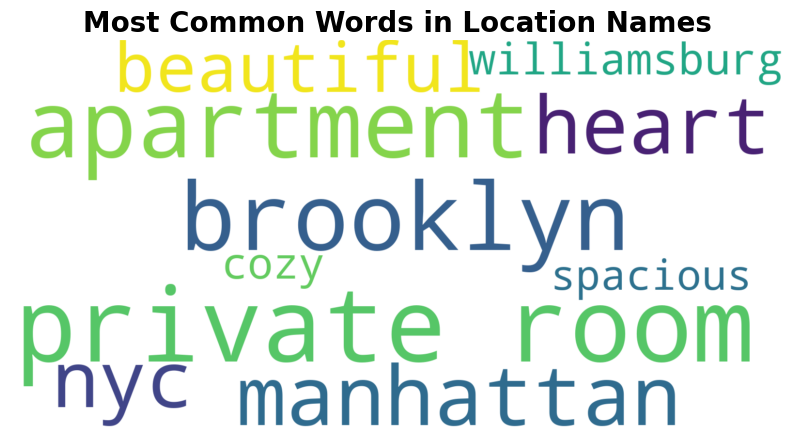

In [42]:
# Generate a word cloud for the 'nome' column in the 'data' DataFrame
df_words = plotter.plot_wordcloud(
    data, 
    text_column="nome", 
    max_words=10, 
    title="Palavras mais comuns nos nomes do anuncio"
)



Ao observarmos os dados, percebemos que existe uma associa√ß√£o entre o padr√£o de texto utilizado nos an√∫ncios e os valores mais altos de pre√ßo. Palavras como **"studio", "spacious", "Manhattan", "bedroom"** e **"apt"** est√£o frequentemente relacionadas a acomoda√ß√µes mais caras. Isso sugere que termos que destacam caracter√≠sticas como **espa√ßo, localiza√ß√£o privilegiada e conforto** podem estar associados a pre√ßos mais elevados, refletindo o valor percebido pelo cliente na escolha do im√≥vel.

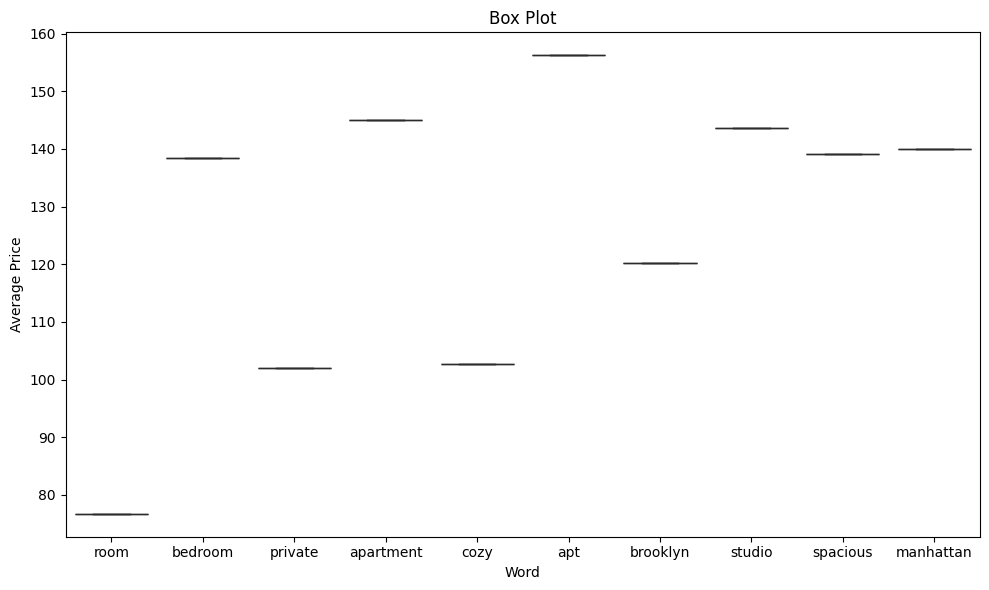

In [43]:
# Plot price distributions from common words
df_price_distribution = aux.plot_price_distribution(
    data=data, text_column="nome", price_column="price", df_words=df_words
)


# Modelling

### **Etapas de Pr√©-processamento**  

Neste c√≥digo, estamos criando um pipeline para transformar os dados de forma adequada para um modelo de machine learning, garantindo que todas as vari√°veis sejam tratadas corretamente antes da modelagem.  

### **1. C√≥pia dos Dados**  
Inicialmente, criamos uma c√≥pia do dataset original (`data.copy()`). Isso √© essencial para preservar os dados originais e evitar modifica√ß√µes indesejadas que possam comprometer a integridade do conjunto de dados.  

### **2. Escolha das Vari√°veis**  

- **Vari√°veis Categ√≥ricas**: S√£o aquelas que representam grupos ou categorias distintas. Essas vari√°veis ser√£o transformadas utilizando a t√©cnica de codifica√ß√£o `OneHotEncoder`, que converte cada categoria em uma coluna bin√°ria. As vari√°veis escolhidas foram:  
  - `bairro_group`, `bairro`, `room_type`, `gender`  
  Essas vari√°veis foram selecionadas com base na an√°lise explorat√≥ria dos dados, pois demonstraram estar correlacionadas com varia√ß√µes nos pre√ßos dos an√∫ncios.  

- **Vari√°veis Num√©ricas**: Cont√™m valores cont√≠nuos e, neste caso, ser√£o mantidas sem transforma√ß√£o. As vari√°veis utilizadas s√£o:  
  - `minimo_noites`, `numero_de_reviews`, `reviews_por_mes`,  
    `calculado_host_listings_count`, `disponibilidade_365`, `days_since_last_review`  
  Essas vari√°veis num√©ricas foram mantidas integralmente, pois representam informa√ß√µes relevantes que podem impactar a previs√£o do pre√ßo.  

### **3. Remo√ß√£o de Valores Nulos**  
As linhas com valores faltantes (`NaN`) s√£o removidas para garantir que o modelo seja treinado apenas com dados completos e consistentes.  

### **4. Transforma√ß√µes**  

- **Vari√°veis Categ√≥ricas**: S√£o codificadas utilizando `OneHotEncoder`, transformando cada categoria em uma vari√°vel bin√°ria. Isso permite que o modelo utilize informa√ß√µes categ√≥ricas sem perder rela√ß√µes importantes entre os grupos.  
- **Vari√°veis Num√©ricas**: S√£o passadas diretamente para o modelo (`passthrough`), pois j√° est√£o no formato adequado para a modelagem.  

### **5. Pipeline de Pr√©-processamento**  
Por fim, um pipeline √© criado utilizando `ColumnTransformer`, aplicando as transforma√ß√µes de forma separada para vari√°veis categ√≥ricas e num√©ricas. Isso garante que os dados estejam padronizados e preparados para alimentar o modelo de machine learning.  

---

### **Descri√ß√£o do Problema**  

O problema que estamos abordando √© um **problema de regress√£o**, pois buscamos prever o pre√ßo dos an√∫ncios, que √© uma vari√°vel num√©rica cont√≠nua. Modelos de regress√£o s√£o utilizados quando o objetivo √© estimar um valor quantitativo a partir de um conjunto de vari√°veis preditoras.  

No contexto deste projeto, nosso modelo de regress√£o aprender√° a identificar padr√µes nos dados e a prever o pre√ßo de um im√≥vel com base em caracter√≠sticas como localiza√ß√£o (`bairro`, `bairro_group`), tipo de acomoda√ß√£o (`room_type`), caracter√≠sticas do anfitri√£o (`calculado_host_listings_count`), disponibilidade (`disponibilidade_365`), entre outras vari√°veis.  

O objetivo final √© desenvolver um modelo robusto que possa fornecer estimativas precisas de pre√ßos, auxiliando tanto propriet√°rios quanto consumidores a tomar decis√µes mais embasadas no mercado de hospedagem.  

---

### **M√©tricas de Avalia√ß√£o**  

Para avaliar o desempenho do modelo, utilizamos tr√™s m√©tricas principais: **MAE (Mean Absolute Error)**, **\( R^2 \) (Coeficiente de Determina√ß√£o)** e **Theil‚Äôs U Statistic**.  

- **MAE (Erro M√©dio Absoluto)**: Mede a m√©dia dos erros absolutos entre os valores reais e as previs√µes. Essa m√©trica √© √∫til porque fornece uma interpreta√ß√£o direta do erro m√©dio em unidades da vari√°vel de resposta (neste caso, o pre√ßo). Quanto menor o MAE, melhor o desempenho do modelo.  

- **\( R^2 \) (Coeficiente de Determina√ß√£o)**: Mede a propor√ß√£o da variabilidade da vari√°vel resposta que √© explicada pelo modelo. O \( R^2 \) varia entre 0 e 1, onde valores mais pr√≥ximos de 1 indicam um ajuste melhor do modelo aos dados.  

- **Theil‚Äôs U Statistic**: Essa m√©trica compara a performance do modelo com a de um modelo ing√™nuo (como uma previs√£o baseada na m√©dia dos valores passados). Se \( U < 1 \), o modelo √© melhor que a previs√£o ing√™nua; se \( U > 1 \), o modelo apresenta desempenho inferior. Essa m√©trica √© √∫til para avaliar se o modelo realmente traz melhorias em rela√ß√£o a previs√µes simples.  

O uso dessas m√©tricas permite uma avalia√ß√£o abrangente do modelo, considerando tanto o erro absoluto quanto a capacidade de explica√ß√£o dos dados e sua efetividade em rela√ß√£o a um modelo de refer√™ncia.

In [16]:
data_modelling = data.copy()

# Define the columns
categorical_features = [
    "bairro_group", "bairro", "room_type", "gender"
]
numerical_features = [
    "minimo_noites", "numero_de_reviews", "reviews_por_mes",
    "calculado_host_listings_count", "disponibilidade_365", "days_since_last_review"
]

# Remove rows with NaN values
data_modelling = data_modelling.dropna()

# Transformer for categorical variables
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Transformer for numeric variables (no transformation applied)
numerical_transformer = "passthrough"

# Applying transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])



1. **Separa√ß√£o das Colunas de Features e Target**:
   - **`y = data_modelling["price"]`**: A vari√°vel target (`y`) √© definida como a coluna `price`, que cont√©m o pre√ßo dos an√∫ncios e √© o que queremos prever.
   - **`X = data_modelling.drop(columns=["price"])`**: As features (`X`) s√£o todas as colunas do dataset, exceto a coluna `price`. Ou seja, todas as vari√°veis preditoras ser√£o usadas para treinar o modelo.

2. **Divis√£o em Conjunto de Treinamento e Tempor√°rio**:
   - **`train_test_split(X, y, test_size=0.3, random_state=42)`**: A fun√ß√£o `train_test_split` √© utilizada para dividir os dados em dois conjuntos:
     - **Treinamento (70%)**: A maior parte dos dados, que ser√° usada para treinar o modelo.
     - **Tempor√°rio (30%)**: A parte restante, que ser√° dividida posteriormente entre valida√ß√£o e teste. A semente `random_state=42` √© definida para garantir que a divis√£o seja reprodut√≠vel.

   Aqui, os dados s√£o divididos em `X_train`, `X_temp` (features) e `y_train`, `y_temp` (target), onde:
   - `X_train` e `y_train` s√£o os dados de treinamento.
   - `X_temp` e `y_temp` cont√™m os dados tempor√°rios, que ser√£o separados em valida√ß√£o e teste na pr√≥xima etapa.

3. **Divis√£o do Conjunto Tempor√°rio em Valida√ß√£o e Teste**:
   - **`train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)`**: Agora, os dados tempor√°rios (`X_temp`, `y_temp`) s√£o divididos novamente em:
     - **Valida√ß√£o (20%)**: Esse conjunto ser√° usado para avaliar o desempenho do modelo durante o treinamento e ajustar par√¢metros.
     - **Teste (10%)**: Esse conjunto ser√° utilizado para testar o modelo final ap√≥s o treinamento.

   A divis√£o aqui √© feita com `test_size=1/3`, ou seja, 1/3 dos dados tempor√°rios s√£o alocados para o conjunto de teste, deixando 2/3 para valida√ß√£o.

4. **Aplica√ß√£o das Transforma√ß√µes do Pipeline**:
   - **`X_train_transformed = pipeline.fit_transform(X_train)`**: O pipeline, que aplica as transforma√ß√µes necess√°rias nas vari√°veis (como a codifica√ß√£o das vari√°veis categ√≥ricas), √© ajustado (fit) e transformado (transform) no conjunto de treinamento (`X_train`).
   - **`X_val_transformed = pipeline.transform(X_val)`** e **`X_test_transformed = pipeline.transform(X_test)`**: Para os conjuntos de valida√ß√£o e teste, apenas a transforma√ß√£o √© aplicada (sem o ajuste), garantindo que as transforma√ß√µes sejam consistentes com as realizadas no conjunto de treinamento.


In [17]:
# Separate columns features and target
y = data_modelling["price"]
X = data_modelling.drop(columns=["price"])

# Split into training (70%) and temporary (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Split the temporary set into validation (20%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42
)

# Applying the transformations from the pipeline
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)




# Regress√£o Linear

Os resultados da regress√£o linear mostram um desempenho relativamente baixo do modelo na predi√ß√£o dos dados. Primeiramente, a escolha do hiperpar√¢metro fit_intercept=False indica que o modelo foi treinado sem um termo de intercepta√ß√£o, assumindo que os dados j√° estavam centralizados ou que a rela√ß√£o entre as vari√°veis explicativas e a vari√°vel-alvo n√£o requer um deslocamento adicional.

O coeficiente de determina√ß√£o ùëÖ¬≤, que mede a propor√ß√£o da vari√¢ncia explicada pelo modelo, √© de 0,2288 para o conjunto de valida√ß√£o. Esse valor sugere que apenas cerca de 22,88% da varia√ß√£o da vari√°vel dependente √© explicada pelo modelo, indicando um ajuste fraco.

Nas m√©tricas de erro, o Erro M√©dio Absoluto (MAE) foi 59,63, o que indica o erro m√©dio em unidades da vari√°vel predita. Esse valor sugere que, em m√©dia, as previs√µes do modelo se desviam cerca de 59,63 unidades dos valores reais.

O Theil‚Äôs U foi 0,4439, o que indica que o modelo possui um erro consider√°vel em rela√ß√£o a uma previs√£o ing√™nua (como uma previs√£o baseada na m√©dia passada). Em geral, valores de Theil pr√≥ximos de 0 indicam boas previs√µes, enquanto valores acima de 1 sugerem um modelo pouco √∫til. O valor obtido (pr√≥ximo de 0,44) indica que o modelo tem um desempenho melhor do que uma previs√£o ing√™nua, mas ainda apresenta limita√ß√µes.

No geral, os resultados sugerem que a regress√£o linear n√£o capturou adequadamente a rela√ß√£o entre as vari√°veis do conjunto de dados.

In [18]:
# Define the model and parameter grid
model_lr = LinearRegression()


param_grids_lr = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
}

# Configure GridSearchCV (without automatic refitting)
grid_search_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grids_lr['Linear Regression'],
    scoring='r2',
    cv=5,  
    n_jobs=-1,
    refit=True  
)


best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_lr,
    grid_search=grid_search_lr,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)

------------------------------Melhores hiperpar√¢metros------------------------------
fit_intercept: True
--------------------------------------------------------------------------------
------------------------------M√©tricas de R¬≤ para o modelo------------------------------
R¬≤ para o conjunto de valida√ß√£o: 0.23

------------------------------M√©tricas  para o modelo------------------------------
              model        MAE        R2     theil
0  LinearRegression  59.498186  0.106877  0.443914


Em termos de erro m√©dio absoluto (MAE), o Lasso teve um desempenho ligeiramente melhor, com um valor de 59.095 em compara√ß√£o com 59.498 da Regress√£o Linear.  
Isso significa que, em m√©dia, os erros absolutos do Lasso foram um pouco menores, indicando previs√µes mais precisas. O coeficiente de determina√ß√£o R¬≤, que mede a capacidade do modelo de explicar a variabilidade dos dados, foi praticamente o mesmo para ambos os modelos, ficando em torno de 0.1069. Esse valor relativamente baixo sugere que nenhum dos modelos conseguiu capturar bem a rela√ß√£o entre as vari√°veis preditoras e a vari√°vel alvo. 
Al√©m disso, o √≠ndice de Theil, que avalia a precis√£o das previs√µes em compara√ß√£o com um modelo de refer√™ncia, tamb√©m foi praticamente id√™ntico nos dois casos, ficando em torno de 0.4439, refor√ßando que ambos os modelos tiveram desempenhos muito pr√≥ximos.   
No entanto, o Lasso pode ter uma leve vantagem, pois al√©m de apresentar um erro m√©dio um pouco menor, ele tem a capacidade de penalizar coeficientes irrelevantes, ajudando a evitar overfitting e tornando o modelo mais robusto. No entanto, dado o baixo R¬≤, pode ser interessante testar abordagens diferentes, como a inclus√£o de novas vari√°veis, transforma√ß√£o dos dados ou at√© mesmo modelos mais sofisticados que consigam capturar melhor a estrutura dos dados.

In [19]:
# Define the model
model_lasso =  Lasso()

# paramns for model
param_grids_lasso = {

    'Lasso': {
        'alpha': [0.1, 1.0, 10.0]
    }
}


# Configure GridSearchCV for hyperparameter tuning
grid_search_lasso = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grids_lasso['Lasso'],
    scoring="r2",
    cv=5,  
    n_jobs=-1 
)

best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_lasso,
    grid_search=grid_search_lasso,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)


------------------------------Melhores hiperpar√¢metros------------------------------
alpha: 0.1
--------------------------------------------------------------------------------
------------------------------M√©tricas de R¬≤ para o modelo------------------------------
R¬≤ para o conjunto de valida√ß√£o: 0.22

------------------------------M√©tricas  para o modelo------------------------------
              model        MAE        R2     theil
0  LinearRegression  59.498186  0.106877  0.443914
1             Lasso  59.095208  0.106881  0.443913


Os resultados mostram o desempenho de tr√™s modelos de regress√£o: Regress√£o Linear, Lasso e Random Forest. Comparando as m√©tricas, observa-se que o **Random Forest Regressor** teve o melhor desempenho entre os tr√™s, com um erro m√©dio absoluto (MAE) de 53.449, significativamente menor do que os valores de 59.498 da Regress√£o Linear e 59.095 do Lasso.  
Isso indica que as previs√µes do Random Forest foram, em m√©dia, mais pr√≥ximas dos valores reais. Al√©m disso, o coeficiente de determina√ß√£o R¬≤ para o Random Forest foi de 0.141, um aumento em rela√ß√£o aos 0.106 dos outros modelos, sugerindo que ele conseguiu explicar uma parcela maior da variabilidade dos dados.  
O √≠ndice de Theil tamb√©m foi menor para o Random Forest (0.426), refor√ßando que suas previs√µes foram mais confi√°veis e menos distantes da realidade em compara√ß√£o com os demais modelos. Esses resultados indicam que o Random Forest conseguiu capturar melhor os padr√µes dos dados, possivelmente devido √† sua capacidade de modelar rela√ß√µes n√£o lineares e intera√ß√µes entre vari√°veis, o que os modelos lineares n√£o conseguem fazer. 
Mesmo assim, o R¬≤ de 0.141 ainda √© relativamente baixo, sugerindo que h√° espa√ßo para melhorias, seja por meio do ajuste de hiperpar√¢metros, inclus√£o de novas vari√°veis ou experimenta√ß√£o com outros modelos mais sofisticados.

In [20]:
# Define the model
model_rf = RandomForestRegressor()


# Define the hyperparameter grid for tuning
param_grids_rf = {
    'Random Forest': {
        'n_estimators': [40, 50],
        'max_depth': [None, 30, 40],
        'min_samples_split': [2, 8],
        'min_samples_leaf': [1, 9],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
}

# Configure GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(), 
    param_grid=param_grids_rf['Random Forest'], 
    scoring='r2',
    cv=5,
    n_jobs=-1
)

best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_rf,
    grid_search=grid_search_rf,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)


------------------------------Melhores hiperpar√¢metros------------------------------
bootstrap: False
max_depth: None
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 8
n_estimators: 40
--------------------------------------------------------------------------------
------------------------------M√©tricas de R¬≤ para o modelo------------------------------
R¬≤ para o conjunto de valida√ß√£o: 0.25

------------------------------M√©tricas  para o modelo------------------------------
                   model        MAE        R2     theil
0       LinearRegression  59.498186  0.106877  0.443914
1                  Lasso  59.095208  0.106881  0.443913
2  RandomForestRegressor  53.449370  0.141283  0.426797


# Prevendo novo valor suposto

Nesta etapa, buscamos prever um novo valor com base nos dados e no modelo desenvolvido, conforme proposto pelo desafio. Para isso, criamos uma nova entrada contendo as caracter√≠sticas especificadas e aplicamos os mesmos tratamentos e pr√©-processamentos utilizados anteriormente nos dados de treinamento. Dessa forma, garantimos que a nova entrada esteja no formato adequado para ser processada pelo modelo e gerar uma previs√£o precisa.

In [ ]:
new_data = {
    'id': 2595,  
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

# Create a DataFrame with input data
input_df = pd.DataFrame([new_data])

# Apply predict_gender on 'host_name' column
input_df['gender'] = input_df['host_name'].apply(
    lambda name: aux.predict_gender(name)
)

# Replace specific gender values for consistency
input_df['gender'] = input_df['gender'].replace(
    {'mostly_female': 'female', 'mostly_male': 'male'}
)

# Convert 'ultima_review' to date format
input_df['ultima_review'] = pd.to_datetime(input_df['ultima_review'])

# Create 'days_since_last_review' column
input_df['days_since_last_review'] = (
    pd.Timestamp.today() - input_df['ultima_review']
).dt.days

# Ensure there are no NaN values in 'days_since_last_review'
input_df = input_df.dropna(subset=['days_since_last_review'])

# Using the pipeline for transformation
teste_new = pipeline.transform(input_df)



Abaixo fazemos a previs√£o com o modelo que se saiu melhor com os dados, o modelo de floresta ale√°toria.

In [ ]:
y_pred_rf_new = grid_search_rf.best_estimator_.predict(teste_new)
print("Valor da Previs√£o com RandomForest",y_pred_rf_new)

Nesta etapa, salvamos o **modelo Random Forest**, que apresentou o melhor desempenho entre os modelos avaliados, na pasta **models**.    
O modelo Random Forest foi escolhido devido √† sua capacidade de capturar padr√µes complexos nos dados e seu bom desempenho nas tarefas de previs√£o.   
Ao salvar o modelo, garantimos que ele possa ser carregado e reutilizado futuramente para fazer previs√µes em novos dados, sem a necessidade de treinar o modelo novamente. Isso tamb√©m facilita a integra√ß√£o do modelo em aplica√ß√µes ou pipelines de produ√ß√£o.

In [ ]:
joblib.dump(grid_search_rf.best_estimator_, 'models/modelo_RandomForest.pkl')

# Verificando se a pasta 'modelo' existe, sen√£o cria
if not os.path.exists('models'):
    os.makedirs('models')